# Sensitivity analysis with SALib

We have got the single parts now for the sensitivity analysis. We are now using the global sensitivity analysis methods of the Python package SALib, available on:

https://github.com/jdherman/SALib

As a start, we will test the sensitivity of the model at each drillhole position separately. As parameters, we will use the parameters of the fault events: dip, dip direction, and slip.

In [1]:
from IPython.core.display import HTML
css_file = 'pynoddy.css'
HTML(open(css_file, "r").read())

In [2]:
%matplotlib inline

In [3]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
# adjust some settings for matplotlib
from matplotlib import rcParams
# print rcParams
rcParams['font.size'] = 15
# determine path of repository to set paths corretly below
os.chdir(r'../../../pynoddy/docs/notebooks/')
repo_path = os.path.realpath('../..')
import pynoddy.history
import pynoddy.experiment
rcParams.update({'font.size': 20})

## Model set-up

We use the two-fault model from previous examples and assign parameter ranges with a dictionary:

In [6]:
reload(pynoddy.history)
import pynoddy.experiment.sensitivity_analysis
reload(pynoddy.experiment.sensitivity_analysis)
# Start again with the original model
his_filename = "two_faults_sensi.his"
sa = pynoddy.experiment.sensitivity_analysis.SensitivityAnalysis(history = his_filename)

# Initialise list
param_stats = []

# Add one entry as dictionary with relevant properties:

# for event 2:
param_stats.append({'event' : 2, 'parameter' : 'Dip', 'min' : 55., 'max' : 65., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 60., 'initial' : 60.})
param_stats.append({'event' : 2, 'parameter' : 'Dip Direction', 'min' : 85., 'max' : 95., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 90., 'initial' : 90.})
param_stats.append({'event' : 2, 'parameter' : 'Slip', 'min' : 900., 'max' : 1100., 
                    'type' : 'normal', 'stdev' : 500, 'mean' : 1000., 'initial' : 1000.})
# for event 3:
param_stats.append({'event' : 3, 'parameter' : 'Dip', 'min' : 55., 'max' : 65., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 60., 'initial' : 60.})
param_stats.append({'event' : 3, 'parameter' : 'Dip Direction', 'min' : 265., 'max' : 275., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 270., 'initial' : 270.})
param_stats.append({'event' : 3, 'parameter' : 'Slip', 'min' : 900., 'max' : 1100., 
                    'type' : 'normal', 'stdev' : 500, 'mean' : 1000., 'initial' : 1000.})

sa.set_parameter_statistics(param_stats)

## Define sampling lines

As before, we need to define points in the model (or lines) which we want to evaluate the sensitivity for:

In [7]:
# sa.add_sampling_line(5000, 3500, label = 'centre')
sa.add_sampling_line(2500, 3500, label = 'left')
# sa.add_sampling_line(7500, 3500, label = 'right')
# sa.add_sampling_line(4000, 3500, label = 'compare')

And, again, we "freeze" the base state for later comparison and distance caluclations:

In [16]:
sa.freeze()

## Setting-up the parameter set

For use with SALib, we have to define a parameter set as a text file (maybe there is a different way directly in Python - something to figure out for the future). The sensitivity object has a method to do that automatically:

In [17]:
param_file = "params_file_tmp.txt"
sa.create_params_file(filename = param_file)

We now invoke the methods of the SALib library to generate parameter data sets that are required for the type of sensitivity analysis that we want to perform:

In [18]:
# import SALib method
from SALib.sample import saltelli

In [19]:
param_values = saltelli.sample(10, param_file, calc_second_order = True)


TypeError: 'int' object has no attribute '__getitem__'

The object 'param_values' is a list of samples for the parameters that are defined in the model, in the order of appearance in param_file, e.g.:

In [ ]:
param_values[0]

## Calculating distances for all parameter sets

We now need to create a model realisation for each of these parameter sets and calculate the distance between the realisation and the base model at the position of the defined sampling lines. As we are not (always) interested in keeping the results of all realisations, those steps are combined and only the calculated distance is retained (per default):



In [ ]:
distances = sa.determine_distances(param_values = param_values)

In [ ]:
# plot(sa.get_model_lines(model_type = 'base'))
plt.plot(sa.get_model_lines(model_type = 'current'))

In [ ]:
# Just to check if we actualy did get different models:
plt.plot(distances, '.-k')
plt.title("Model distances")
plt.xlabel("Sensitivity step")
plt.ylabel("Distance")

## Sensitivity analysis

We can now analyse the sensitivity of the modelled stratigraphy along the defined vertical lines ("drillholes") with respect to the model parameters:

In [ ]:
# save results
results_file = 'dist_tmp.txt'
np.savetxt(results_file, distances, delimiter=' ')

In [ ]:
from SALib.analyze import sobol

In [ ]:
Si = sobol.analyze(param_file, results_file, 
                   column = 0, 
                   conf_level = 0.95,
                   calc_second_order = True, 
                   print_to_console=False)

In [ ]:
# create composite matrix for sensitivities
n_params = 6
comp_matrix = np.ndarray(shape = (n_params,n_params))
for j in range(n_params):
    for i in range(n_params):
        if i == j:
            comp_matrix[i,j] = Si['S1'][i]
        else:
            comp_matrix[i,j] = Si['S2'][i,j]
            comp_matrix[j,i] = Si['S2'][i,j]
            
# print comp_matrix

# define labels for figure: phi = dip, d = dip direction, s = slip, subscript = fault event
label_names = ["","$\phi_1$", "$d_1$", "$s_1$", "$\phi_2$", "$d_2$", "$s_2$"]

# Create figure
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(comp_matrix, interpolation='nearest', cmap='RdBu_r', 
               vmax = np.max(np.abs(comp_matrix)),
                vmin = -np.max(np.abs(comp_matrix)),

)

ax.yaxis.set_ticks_position("both")
ax.xaxis.set_ticks_position("top")

ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# ax.set_title("Sensitivities")

ax.set_xlabel("Parameter Sensitivities")

fig.colorbar(im)

plt.tight_layout()
# plt.savefig("two_fault_sensi.png")

## Reading parameter ranges from file

So, now that we have all the required ingredients for the sensitivity analysis, we can make life a bit easier with more automation. First, instead of defining parameters in a dictionary as above, we can actually read them in from a csv file (e.g. saved from Excel as Windows-csv file).

In order to be read in correctly, the header should contain the labels:

- 'event' : event id
- 'parameter' : Noddy parameter ('Dip', 'Dip Direction', etc.)
- 'min' : minimum value
- 'max' : maximum value
- 'initial' : initial value

In addition, it is possible to define PDF type and parameters. For now, the following settings are supported:

- 'type' = 'normal' 
- 'stdev' : standard deviation
- 'mean' : mean value (default: 'initial' value)

We can read in the parameters simply with:

In [ ]:
reload(pynoddy.history)
reload(pynoddy.experiment)
# Start again with the original model
his_filename = "two_faults_sensi.his"
sa = pynoddy.experiment.SensitivityAnalysis(history = his_filename)
sa.load_parameter_file("params_fault_model.csv")

The only further aspect we need to define are the sampling lines:

In [ ]:
# sa.add_sampling_line(5000, 3500, label = 'centre')
sa.add_sampling_line(2500, 3500, label = 'left')
# sa.add_sampling_line(7500, 3500, label = 'right')
# sa.add_sampling_line(4000, 3500, label = 'compare')

And then we know everything to perform the sensitivity analysis. The relevant steps are combined in one method:

In [ ]:
sa.perform_analsis(10)

In [ ]:
sa.plot_distances()

In [ ]:
sa.plot_sensitivity_matrix()

In [ ]:
# for event 2:
param_stats.append({'event' : 2, 'parameter' : 'Dip', 'min' : 55., 'max' : 65., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 60., 'initial' : 60.})
param_stats.append({'event' : 2, 'parameter' : 'Dip Direction', 'min' : 85., 'max' : 95., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 90., 'initial' : 90.})
param_stats.append({'event' : 2, 'parameter' : 'Slip', 'min' : 900., 'max' : 1100., 
                    'type' : 'normal', 'stdev' : 500, 'mean' : 1000., 'initial' : 1000.})
# for event 3:
param_stats.append({'event' : 3, 'parameter' : 'Dip', 'min' : 55., 'max' : 65., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 60., 'initial' : 60.})
param_stats.append({'event' : 3, 'parameter' : 'Dip Direction', 'min' : 265., 'max' : 275., 
                    'type' : 'normal', 'stdev' : 10., 'mean' : 270., 'initial' : 270.})
param_stats.append({'event' : 3, 'parameter' : 'Slip', 'min' : 900., 'max' : 1100., 
                    'type' : 'normal', 'stdev' : 500, 'mean' : 1000., 'initial' : 1000.})



In [ ]:
sa.param_stats

In [ ]:
sa.plot_section(model_type = "base")

In [ ]:
plt.plot(sa.get_drillhole_data(4000, 3500))
plt.plot(sa.get_model_lines())

In [ ]:
reload(pynoddy.history)
reload(pynoddy.experiment)
sa2 = pynoddy.experiment.Experiment(history = "two_faults_sensi.his")


In [ ]:
sa2.write_history("test5.his")

In [ ]:
nm = pynoddy.history.NoddyHistory(history = "two_faults_sensi.his")
# nm.determine_events()
nm.write_history("test6.his")

In [ ]:
param_values[0]

In [22]:
reload(pynoddy.history)
reload(pynoddy.experiment)
# Start again with the original model
his_filename = "two_faults_sensi.his"
sa = pynoddy.experiment.SensitivityAnalysis(history = his_filename)

sa.freeze()
# sa.change_event_params({3 : {'Slip' : 500.}})
sa.change_event_params({3 : {'Dip' : 15.}})

TypeError: 'module' object is not callable

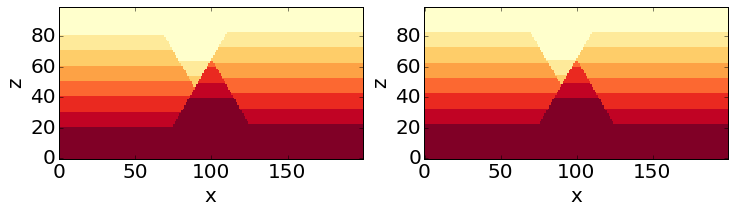

In [23]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sa.plot_section(ax = ax1, colorbar = False, title = "")
sa.plot_section(ax = ax2, model_type = "base", colorbar = False, title = "")

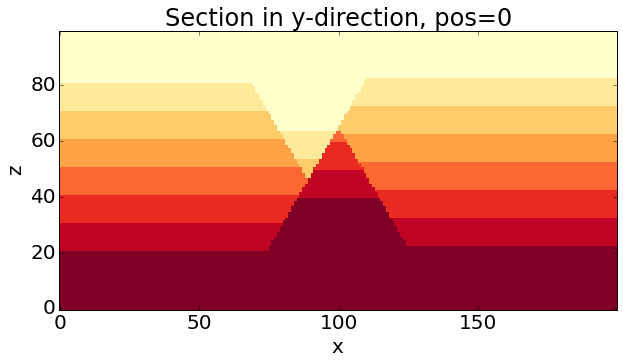

In [21]:
sa.change_event_params({3 : {'Slip' : 100.}})
sa.plot_section()

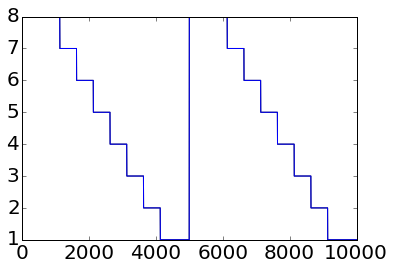

In [20]:
# sa.add_sampling_line(5000, 3500, label = 'centre')
# sa.add_sampling_line(2500, 3500, label = 'left')
sa.add_sampling_line(7500, 3500, label = 'right')
# sa.add_sampling_line(4000, 3500, label = 'compare')
plt.plot(sa.get_model_lines(), 'k')
plt.plot(sa.get_model_lines(model_type = "base"), 'b')

In [ ]:
pwd